In [41]:
#%matplotlib notebook
%matplotlib inline

import json
from collections import defaultdict
import dateutil.parser
from matplotlib import pylab
import numpy as np
base = 'output/cc/'
documents = json.load(open(base+'documents.json','rb'))
regions = json.load(open('output/regions.json','rb'))
print('Documents',len(documents))
hosts = defaultdict(list) # host:docs
categories = defaultdict(lambda: defaultdict(int)) # host:cat:num

history = defaultdict(lambda: defaultdict(lambda: defaultdict(int))) # host:cat:year:num
general_history = defaultdict(lambda: defaultdict(int)) # cat:year:num
years = set([])
by_region = defaultdict(lambda: defaultdict(int)) # region:cat:n
by_province = defaultdict(lambda: defaultdict(int)) # province:cat:n
by_cap =  defaultdict(lambda: defaultdict(int)) # cap:cat:n
overall = defaultdict(int) #cat:num
noyear = 0

def incr_category(h,c,y):
    global noyear
    overall[c]+=1
    categories[h][c]+=1
    by_region[doc['region']][c]+=1
    by_province[doc['prov']][c]+=1
    by_cap[doc['cap']][c]+=1
    if y:
        history[h][c][y]+=1
        general_history[c][y]+=1
        years.add(y)
    else:
        noyear+=1

archieved = []
for doc in documents:
    h = doc['host']
    c = doc['category']
    if c=='archive':
        continue
    if doc.get('archive_path'):
        archieved.append(doc)
    hosts[h].append(doc)
    y = doc['latest'] or 0
    if y:
        y = dateutil.parser.parse(y).year
    incr_category(h,c,y)

print('Missing date:',noyear)
print('Extracted from archives:',len(archieved))
years = sorted(list(years))
general_proportions = defaultdict(list) #cat:[%] per years
count_history = []
for y in years:
    cat = {} #cat:num in this year
    tot = 0 # total in this year
    for c,yn in general_history.items():
        cat[c] = yn[y]
        tot+=cat[c]
    count_history.append(tot)
    for c,n in cat.items():
        general_proportions[c].append(100.*n/tot)
        
json.dump(general_proportions, open(base+'national_share.json','w'))

# Total docs by host
host_index = np.array(list(hosts.keys()))
total_documents = np.array([len(hosts[h]) for h in host_index])

# opendocument share index
opendocument_share = np.zeros(len(hosts)) 

for i,h in enumerate(host_index):
    tot = sum(categories[h].values())
    for c,val in categories[h].items():
        categories[h][c] = 100.*val/tot
    opendocument_share[i] = categories[h]['opendocument']

# Sort by share, than by total
oi = np.lexsort((1/(total_documents+1), opendocument_share))
host_index = host_index[oi]
opendocument_share = opendocument_share[oi]
print('Hosts',len(hosts))


Documents 51121
Missing date: 4853
Extracted from archives: 0
Hosts 2159


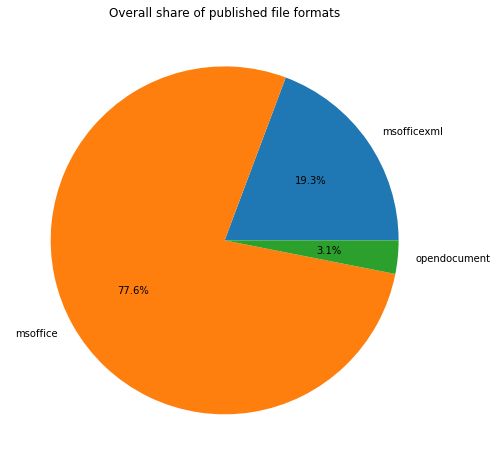

In [44]:
pylab.figure(figsize=(8,8))
pylab.pie(list(overall.values()),labels=overall.keys(), autopct='%.1f%%')
foo=pylab.title('Overall share of published file formats')

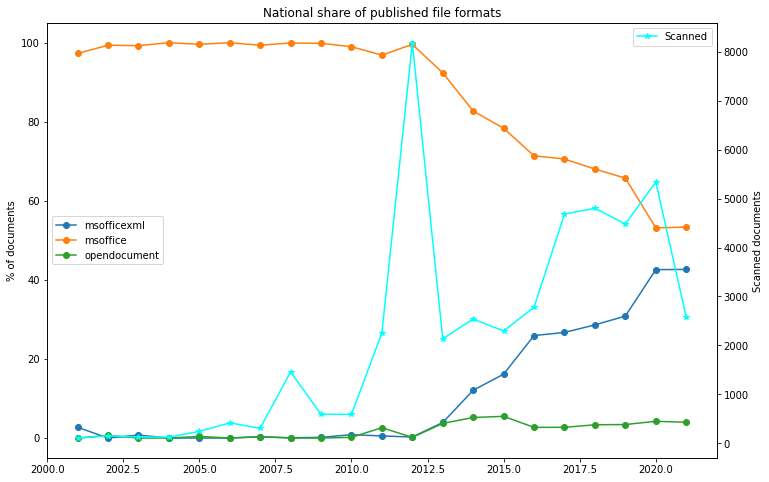

In [46]:
#pylab.figure()
fig,ax = pylab.subplots(figsize=[12,8])
pylab.title('National share of published file formats')
count_history = np.array(count_history)
years = np.array(years)

s = (years<2022) * (years>1990)
m = count_history[s]>100
#s=slice(None,None)
for cat,vals in general_proportions.items():
    ax.plot(years[s][m],np.array(vals)[s][m],'-o',label=cat)
ax.set_ylabel('% of documents')
ax.legend(loc=6)

ax1 = ax.twinx()
ax1.plot(list(years[s][m]),count_history[s][m],'-*',color='cyan',label='Scanned')
ax1.set_ylabel('Scanned documents')
foo=ax1.legend(loc=1)

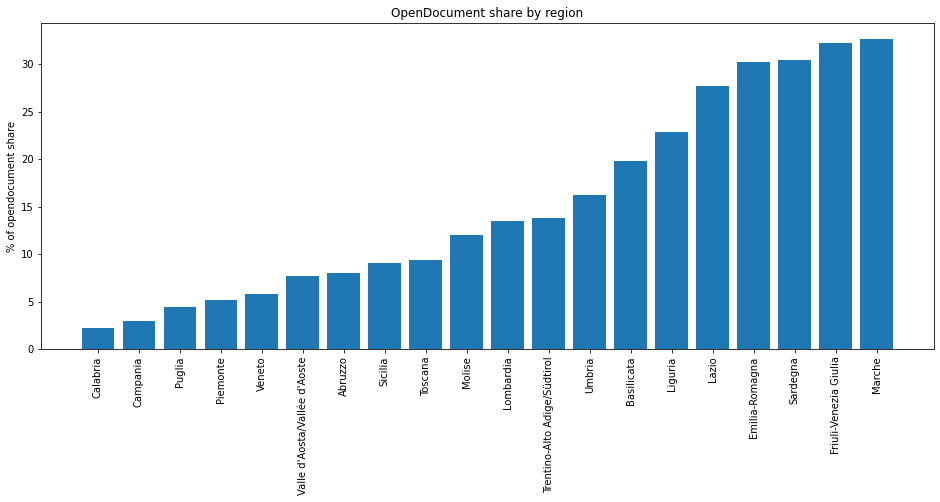

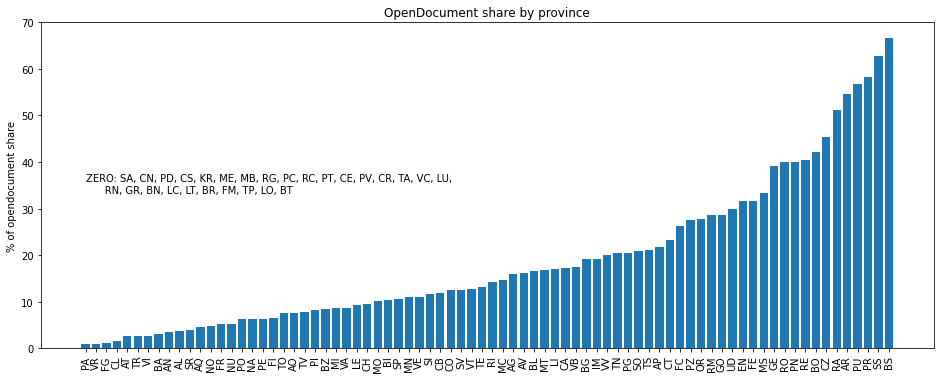

In [18]:
def percent_shares(by_location):
    names = np.array(list(by_location.keys()))
    shares = np.zeros(len(names))
    new = {}
    for i,(r, cat) in enumerate(by_location.items()):
        n = sum(cat.values())
        for c,v in cat.items():
            cat[c]=100.*v/n
        new[r]=cat
        shares[i] = cat['opendocument']
    return new,names,shares

import textwrap

def share_plot(by_location,label):
    out, names, shares = percent_shares(by_location)
    json.dump(out, open(base+label+'_share.json','w'))
    m = shares>0
    oi = np.argsort(shares[m])
    pylab.figure(figsize=(16,6))
    pylab.bar(names[m][oi], shares[m][oi])
    pylab.xticks(rotation = 90)
    pylab.title('OpenDocument share by '+label)
    pylab.ylabel('% of opendocument share')
    z = shares==0
    if sum(z):
        z = textwrap.wrap(', '.join(list(map(str, names[z]))))
        z = '\n      '.join(z)
        pylab.text(0,max(shares)/2,'ZERO: '+z)
    
share_plot(by_region,'region')
share_plot(by_province,'province')

In [19]:
# Convert categories by host into %

N = len(documents)

bestfile = open(base+'best_hosts.csv','w')
def printhost(i):
    h = host_index[i]
    n =len(hosts[h])
    m ='{:.0f}%;\t {};\t {:.2f};\t {}'.format(opendocument_share[i], n,100*n/N, h)
    bestfile.write(m+'\n')
    print(m)

print('# BEST HOSTS')
m = '# Share%; N docs; %  over total scanned; host'
bestfile.write(m+'\n')
print(m)
for i in range(-1,-len(hosts),-1):
    printhost(i)
    
bestfile.close()


# BEST HOSTS
# Share%; N docs; %  over total scanned; host
100%;	 1;	 0.00;	 www.comune.cavriglia.ar.it
100%;	 1;	 0.00;	 www.comune.palaia.pi.it
100%;	 1;	 0.00;	 ordinefrosinone.conaf.it
100%;	 1;	 0.00;	 www.sferisterio.it
100%;	 2;	 0.01;	 www.liceobagatta.it
100%;	 2;	 0.01;	 www.isa12sp.edu.it
100%;	 2;	 0.01;	 www.adbpo.gov.it
100%;	 3;	 0.01;	 www.iissbojano.edu.it
100%;	 4;	 0.01;	 iccicagna.edu.it
100%;	 4;	 0.01;	 www.iccicagna.edu.it
100%;	 7;	 0.02;	 www.liceocopernico.edu.it
97%;	 37;	 0.13;	 www.bs.camcom.it
92%;	 129;	 0.46;	 www.icsmargheritadinavarra.edu.it
91%;	 100;	 0.35;	 www.comune.gaggio-montano.bo.it
89%;	 9;	 0.03;	 www.aziendaforestale.tn.it
88%;	 89;	 0.31;	 aemmelineaambiente.it
87%;	 2108;	 7.44;	 www.agenziademanio.it
86%;	 160;	 0.56;	 www.comune.tempiopausania.ot.it
83%;	 108;	 0.38;	 www.aspbassaromagna.it
82%;	 11;	 0.04;	 www.casalp.it
73%;	 107;	 0.38;	 www.aemmelineaambiente.it
71%;	 7;	 0.02;	 www.aobrotzu.it
70%;	 20;	 0.07;	 www.alfaliguria.it
7